# **Wildfire Burn Area Prediction**  
### *Linear Regression Analysis of Climate and Vegetation Drivers of Burn Severity* 

KEY ANALYSIS:
- Target: log-acres burned [log_acres]
- Primary Predictors:
  1. 30-day precipitation std dev (mm/day)
  2. Maximum daily temperature (°C)
- Validation: 70/30 train-test split
- Metrics: Slope, R², MSE

CORE FINDINGS:
1. All variables exhibit tremendous variance
2. Even for variables with highest correlations, linear regressions have little predictive power (R² = 0.04 at the top end)
3. There is likely strong bias in the data from unaccounted-for seasonal, trend-based, and spatial autocorrelation effects

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Config
plt.style.use('seaborn-v0_8')
pd.options.display.precision = 3
np.random.seed(42)

In [47]:
# Load and transform
df = pd.read_csv(r"/media/scruffy/Elements/python_data/Final/Prepared_Data/all_features.csv").dropna()

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3282006 entries, 90 to 3528305
Data columns (total 68 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Unnamed: 0                    int64  
 1   date                          object 
 2   longitude                     float64
 3   latitude                      float64
 4   temperature_2m                float64
 5   temperature_2m_max            float64
 6   total_precipitation           float64
 7   dewpoint                      float64
 8   soil_moisture                 float64
 9   solar_rad                     float64
 10  thermal_rad                   float64
 11  heat_flux                     float64
 12  potential_evaporation         float64
 13  total_evaporation             float64
 14  highveg_lai                   float64
 15  lowveg_lai                    float64
 16  max_windspeed                 float64
 17  wind_direction                float64
 18  aspect                    

In [52]:
trunk = df.drop(columns=['Unnamed: 0', 'date', 'longitude', 'days_since_rain', 'latitude', 'point_id', 'temperature_2m', 'max_windspeed', 'active_fire'])

In [59]:
trunk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4957 entries, 2034 to 3528179
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   temperature_2m_max            4957 non-null   float64
 1   total_precipitation           4957 non-null   float64
 2   dewpoint                      4957 non-null   float64
 3   soil_moisture                 4957 non-null   float64
 4   solar_rad                     4957 non-null   float64
 5   thermal_rad                   4957 non-null   float64
 6   heat_flux                     4957 non-null   float64
 7   potential_evaporation         4957 non-null   float64
 8   total_evaporation             4957 non-null   float64
 9   highveg_lai                   4957 non-null   float64
 10  lowveg_lai                    4957 non-null   float64
 11  wind_direction                4957 non-null   float64
 12  aspect                        4957 non-null   float64
 13  sl

In [3]:
df = df[df['log_acres']!=0]

In [54]:
trunk['log_acres'] = np.log1p(trunk['active_fire_acres'])

In [55]:
trunk = trunk[trunk['log_acres']!=0]

In [57]:
trunk = trunk.drop(columns= 'active_fire_acres')

In [60]:
predictors = {col: trunk[[col]].values for col in trunk.columns}
y = trunk['log_acres'].values

In [10]:
# Define both predictors
predictors = {
    'precip_30d_std': df[['total_precipitation_30d_std']].values,
    'temp_max': df[['temperature_2m_max']].values,
    'ndvi_90d_diff': df[['ndvi_90_difference']].values,
    'ndvi_30d_std': df[['NDVI_30d_std']].values,
    'solar_rad': df[['solar_rad']].values
}
y = df['log_acres'].values

In [79]:
# Focus variables
X = df[['temperature_2m_max']].values
y = df['log_acres'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

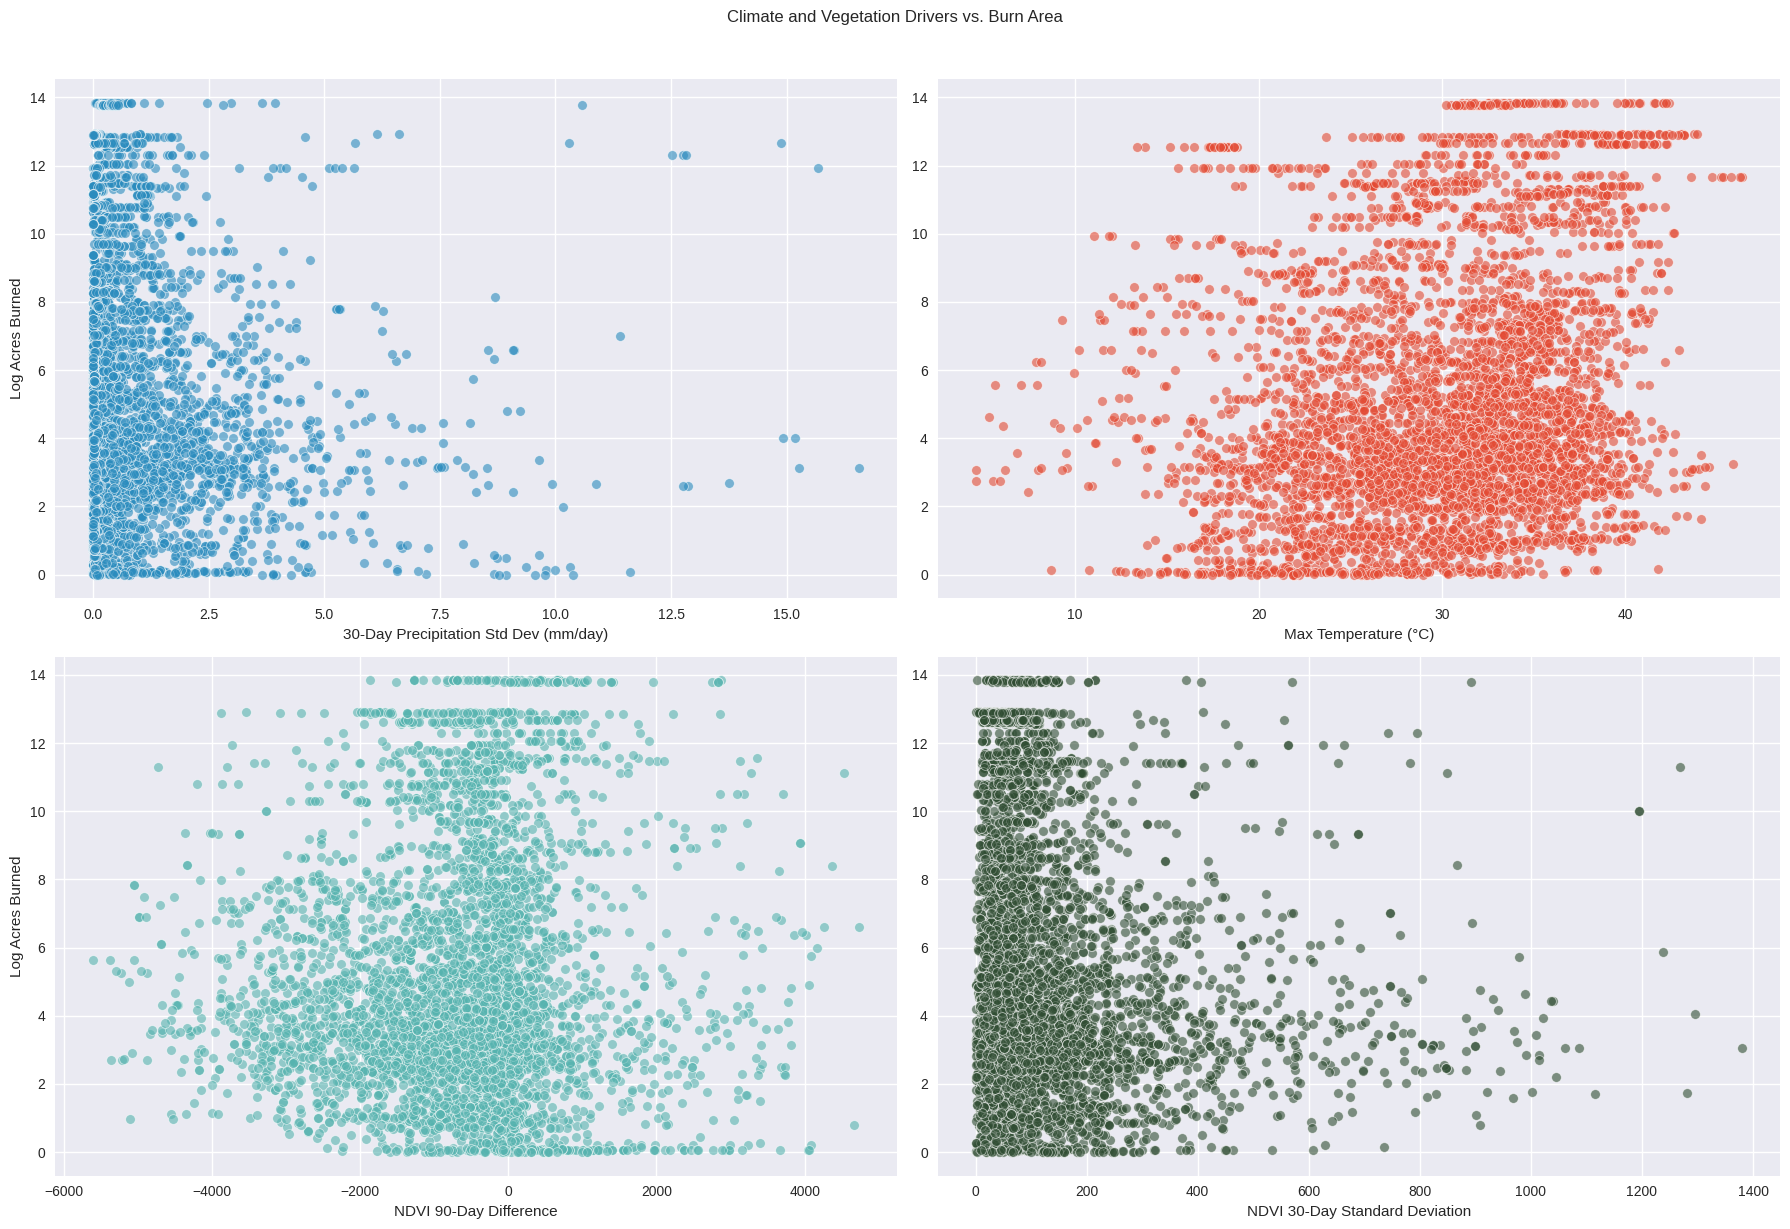

In [77]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Precipitation plot
sns.scatterplot(
    x=df['total_precipitation_30d_std'],
    y=df['log_acres'],
    alpha=0.6,
    color='#2b8cbe',
    ax=ax1
)
ax1.set_xlabel('30-Day Precipitation Std Dev (mm/day)')
ax1.set_ylabel('Log Acres Burned')

# Temperature plot
sns.scatterplot(
    x=df['temperature_2m_max'],
    y=df['log_acres'],
    alpha=0.6,
    color='#e34a33',
    ax=ax2
)
ax2.set_xlabel('Max Temperature (°C)')
ax2.set_ylabel('')  # Remove duplicate y-label

# Vegetation difference plot
sns.scatterplot(
    x=df['ndvi_90_difference'],
    y=df['log_acres'],
    alpha=0.6,
    color='#56b3af',
    ax=ax3
)
ax3.set_xlabel('NDVI 90-Day Difference')
ax3.set_ylabel('Log Acres Burned')

# Vegetation volatility plot
sns.scatterplot(
    x=df['NDVI_30d_std'],
    y=df['log_acres'],
    alpha=0.6,
    color='#304d33',
    ax=ax4
)
ax4.set_xlabel('NDVI 30-Day Standard Deviation')
ax4.set_ylabel('')  # Remove duplicate y-label

plt.suptitle('Climate and Vegetation Drivers vs. Burn Area', y=1.02)
plt.tight_layout()

In [61]:
results = []

for name, X in predictors.items():
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store results
    results.append({
        'predictor': name,
        'slope': model.coef_[0],
        'intercept': model.intercept_,
        'mse': mean_squared_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df[['predictor', 'slope', 'r2', 'mse']])

                       predictor      slope         r2        mse
0             temperature_2m_max  2.463e-02  3.924e-02  3.867e-01
1            total_precipitation  2.416e-02 -8.348e-04  4.028e-01
2                       dewpoint -5.434e-03  8.417e-03  3.991e-01
3                  soil_moisture  5.905e-01  2.596e-03  4.015e-01
4                      solar_rad  1.079e-09 -7.979e-04  4.028e-01
5                    thermal_rad -7.040e-09 -1.200e-04  4.025e-01
6                      heat_flux  4.849e-09  4.496e-04  4.023e-01
7          potential_evaporation -1.167e+01  7.017e-02  3.743e-01
8              total_evaporation -7.622e+00 -8.763e-04  4.029e-01
9                    highveg_lai -6.356e-02  7.966e-03  3.993e-01
10                    lowveg_lai -1.147e-01  3.318e-02  3.891e-01
11                wind_direction -7.190e-04  9.941e-03  3.985e-01
12                        aspect -2.420e-04  1.231e-03  4.020e-01
13                         slope  9.007e-02  2.244e-02  3.935e-01
14        

In [62]:
results_df.sort_values('r2', ascending=False)

,predictor,slope,intercept,mse,r2
58,log_acres,1.000e+00,-6.661e-16,1.014e-31,1.000e+00
17,fires_past_10yrs_count,-2.878e-02,1.823e+00,3.567e-01,1.138e-01
7,potential_evaporation,-1.167e+01,1.366e+00,3.743e-01,7.017e-02
0,temperature_2m_max,2.463e-02,8.618e-01,3.867e-01,3.924e-02
10,lowveg_lai,-1.147e-01,1.800e+00,3.891e-01,3.318e-02
27,temperature_2m_max_7d_mean,2.488e-02,8.739e-01,3.917e-01,2.680e-02
56,extreme_dry_conditions,2.535e-01,1.527e+00,3.933e-01,2.277e-02
13,slope,9.007e-02,1.463e+00,3.935e-01,2.244e-02
18,elevation,1.622e-04,1.482e+00,3.957e-01,1.701e-02
31,dewpoint_7d_mean,-1.292e-02,1.691e+00,3.961e-01,1.586e-02


In [63]:
results_df.to_csv(r"/media/scruffy/Elements/python_data/Final/Prepared_Data/reg_results_all_features.csv", index=False)

In [78]:
print(f"""
Regression Results Rain Volatility:
- Slope: {model.coef_[0]:.3f} log-acres per mm/day
- Intercept: {model.intercept_:.3f}
- MSE: {mse:.3f}
- R²: {r2:.3f}
""")


Regression Results Rain Volatility:
- Slope: -0.219 log-acres per mm/day
- Intercept: 5.178
- MSE: 12.521
- R²: -0.002



In [82]:
print(f"""
Regression Results Max Temp:
- Slope: {model.coef_[0]:.3f} log-acres per Degree Celsius
- Intercept: {model.intercept_:.3f}
- MSE: {mse:.3f}
- R²: {r2:.3f}
""")


Regression Results Max Temp:
- Slope: 0.122 log-acres per Degree Celsius
- Intercept: 1.345
- MSE: 11.961
- R²: 0.042



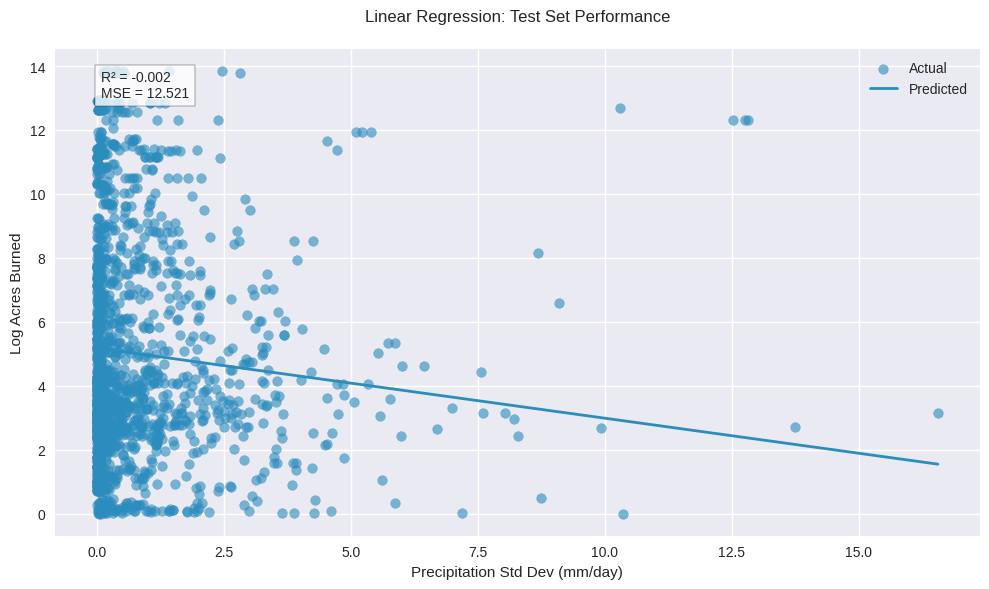

In [63]:
plt.figure(figsize=(10, 6))

# Scatterplot
plt.scatter(
    X_test, y_test,
    color='#2b8cbe',
    alpha=0.6,
    label='Actual'
)

# Regression line
x_range = np.linspace(X.min(), X.max(), 100)
plt.plot(
    x_range, 
    model.predict(x_range.reshape(-1, 1)),
    color='#2b8cbe',
    linewidth=2,
    label='Predicted'
)

# Annotations
plt.text(
    0.05, 0.9,
    f'R² = {r2:.3f}\nMSE = {mse:.3f}',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.xlabel('Precipitation Std Dev (mm/day)')
plt.ylabel('Log Acres Burned')
plt.title('Linear Regression: Test Set Performance', pad=20)
plt.legend()
plt.tight_layout()
plt.savefig('regression_plot.png', dpi=300)

    Trend line does not fit the data well at all. Enormous variance around the low end for precipitation volatility and possible overfitting to outliers.

In [85]:
data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
data.head(30)

,Actual,Predicted
0,4.169,5.283
1,2.906,5.860
2,0.076,4.408
3,2.969,6.118
4,7.406,5.309
5,5.395,5.574
6,4.378,4.475
7,3.836,4.582
8,8.276,5.914
9,0.930,5.048


    Way off.

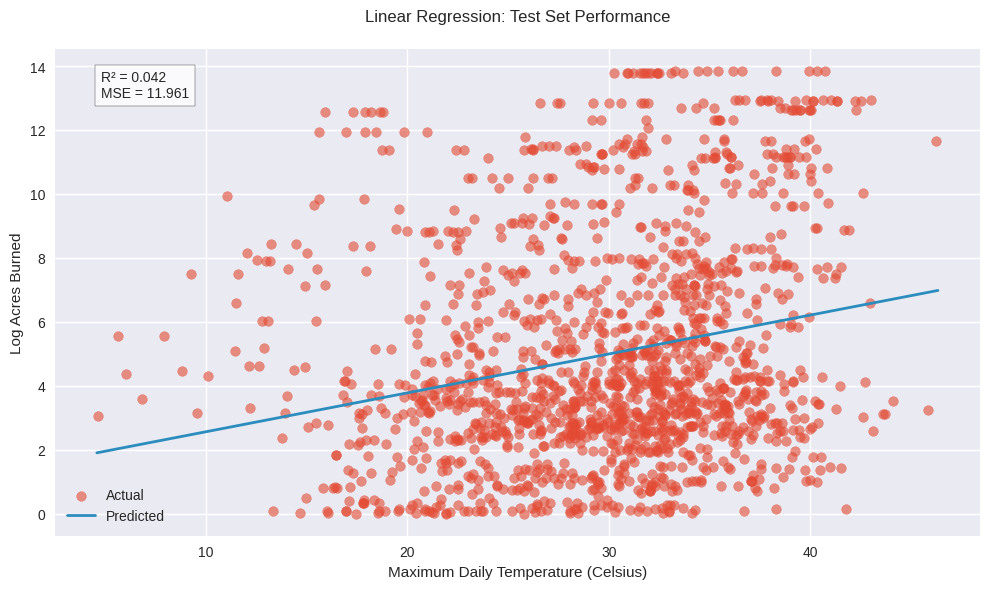

In [48]:
plt.figure(figsize=(10, 6))

# Scatterplot
plt.scatter(
    X_test, y_test,
    color='#e34a33',
    alpha=0.6,
    label='Actual'
)

# Regression line
x_range = np.linspace(X.min(), X.max(), 100)
plt.plot(
    x_range, 
    model.predict(x_range.reshape(-1, 1)),
    color='#2b8cbe',
    linewidth=2,
    label='Predicted'
)

# Annotations
plt.text(
    0.05, 0.9,
    f'R² = {r2:.3f}\nMSE = {mse:.3f}',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.xlabel('Maximum Daily Temperature (Celsius)')
plt.ylabel('Log Acres Burned')
plt.title('Linear Regression: Test Set Performance', pad=20)
plt.legend()
plt.tight_layout()
plt.savefig('regression_plot.png', dpi=300)

    Trend line clearly fits data better here, but still not great.
    Large variance at every level.
    Nonetheless, a definite positive relationship